# Implémentation de la fonction de coût et d'une fonction d'affichage de la matrice de confusion

In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes=['A1', 'A2', 'B1', 'B2', 'C1', 'C2'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

In [3]:
from sklearn.metrics import confusion_matrix
def cost_competition(y_pred_logits, y_true, print_confusion = False, cost_by_level = False):
    y_pred = np.argmax(y_pred_logits, axis=1)
    confusion = confusion_matrix(y_true, y_pred, labels=range(6))
    res = (1/y_true.shape[0]) * np.sum(np.multiply(costs, confusion))
    if print_confusion:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, normalize=False, title='Confusion matrix')
        plt.show()
        plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')
        plt.show()
    
    if not cost_by_level:
        return res
    
    cost_by_level = np.sum(np.multiply(costs, confusion), axis=1)
    return res, cost_by_level

## ULMFiT

Papiers associés:
- [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182)
- [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)


In [4]:
import sys
sys.path.append("../fastai/")
from fastai.text import *
import html

In [5]:
BOS = 'xbos'  # beginning-of-sentence tag
#FLD = 'xfld'  # data field tag
FLD = ''  # data field tag

PATH=Path('data/')

## Données

In [6]:
dataset = pd.read_csv(PATH/'train_cap2018.csv')
real_test_dataset = pd.read_csv(PATH/'test_cap2018.csv')
print(dataset.shape)
for i in dataset['level1'].unique():
    print(i, ' : ', (dataset['level1'] == i).values.sum())

(27310, 60)
C2  :  50
C1  :  491
B2  :  2337
B1  :  5383
A2  :  7688
A1  :  11361


In [7]:
from sklearn.utils import shuffle
random_state = 42
train = shuffle(dataset, random_state=random_state)
print(train.shape)

(27310, 60)


In [8]:
y = train['level1']
X = train['fulltext']
real_test_X = real_test_dataset['fulltext']
#real_test_y = real_test_dataset['level1']
print(X.shape)
print(y.shape)
print(real_test_X.shape)

(27310,)
(27310,)
(13656,)


In [9]:
y = np.array(y.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5}))
CLASSES = [0, 1, 2, 3, 4, 5]

Découpage de l'entrainement en entrainement + validation.

In [10]:
training_size = 0.8

X_train = X[0:int(X.shape[0]*training_size)]
y_train = y[0:int(y.shape[0]*training_size)]

X_val = X[int(X.shape[0]*training_size):]
y_val = y[int(y.shape[0]*training_size):]

print(X_train.head())

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

8447     \n\n      Shopping addictionFrom: catherineTo:...
5545     \n\n      NAME : GavinBestFanEMAIL ADDRESS : x...
25908    \n\n      Hi, My name is Marina. I'm twenty-fi...
13235    \n\n      I think that travel around the world...
13118    \n\n      At 20 september, Madonna will play i...
Name: fulltext, dtype: object
(21848,)
(21848,)
(5462,)
(5462,)


In [11]:
trn_texts = list(X_train)
trn_labels = list(y_train)
real_test_texts = list(real_test_X)

val_texts = list(X_val)
val_labels = list(y_val)

print(trn_texts[0])



      Shopping addictionFrom: catherineTo: xxx@net.comYou have to find other things to do. For  exemple, you can walk in the forest or go to the swimming pool.You should ask you  each time  you want to buy: is it important to have this object?When you want to go shopping, you should have  just a little money. You could't buy when you won't  have money.Good luck.




In [12]:
!mkdir -p ULMFiT/classes/
!mkdir -p ULMFiT/lm/

CLAS_PATH=Path('ULMFiT/classes/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('ULMFiT/lm/')
LM_PATH.mkdir(exist_ok=True)

In [13]:
len(trn_texts),len(val_texts)

(21848, 5462)

In [14]:
col_names = ['labels','text']

In [15]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
df_real_test = pd.DataFrame({'text':real_test_texts, 'labels':[0]*len(real_test_texts)}, columns=col_names)

df_trn.head()

,labels,text
0,1,\n\n Shopping addictionFrom: catherineTo:...
1,2,\n\n NAME : GavinBestFanEMAIL ADDRESS : x...
2,0,"\n\n Hi, My name is Marina. I'm twenty-fi..."
3,1,\n\n I think that travel around the world...
4,1,"\n\n At 20 september, Madonna will play i..."


Sur échantillonnage et sous échantillonnage (uniquement pour les données d'entrainement du classifieur).

In [16]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'val.csv', header=False, index=False)
df_real_test.to_csv(CLAS_PATH/'real_test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

Nous commençons par créer les données pour le modèle de langue (LM). L'objectif du LM est d'apprendre la structure de la langue anglaise. Il apprend le langage en essayant de prédire le mot suivant à partir d'un ensemble de mots précédents (ngrammes). Comme le LM ne classe pas les revues, les étiquettes peuvent être ignorées.

Le LM peut bénéficier de toutes les données textuelles. On utilise donc les quatres ensembles: l'entrainement, la validation, le "faux" test et le "vrai" test (pour lequel nous n'avons pas les niveaux des textes).

Nous concaténons d'abord tous les textes (y compris ceux pour lesquels nous devons évaluer le niveau de langue!). Puis nous utilisons sklearn pour diviser les textes en 90% d'entrainement et 10% de validation.

In [17]:
real_test = pd.read_csv(PATH/'test_cap2018.csv')
real_test = list(real_test['fulltext'])
len(real_test)

13656

In [18]:
print(len(trn_texts))
print(len(val_texts))
print(len(real_test))

21848
5462
13656


In [19]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts,val_texts,real_test]), test_size=0.1)

In [20]:
len(trn_texts), len(val_texts)

(36869, 4097)

In [21]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'val.csv', header=False, index=False)

Arrêt précoce utile pour la suite.

In [22]:
class EarlyStopping(Callback):
    def __init__(self, learner, save_path, enc_path=None, patience=5, metric=0, smaller_is_better=True):
        super().__init__()
        self.learner=learner
        self.save_path=save_path
        self.enc_path=enc_path
        self.patience=patience
        self.metric=metric
        self.smaller_is_better=smaller_is_better
    def on_train_begin(self):
        self.best_val_loss=100
        self.best_acc=0
        self.num_epochs_no_improvement=0
    def on_epoch_end(self, metrics):
        if self.smaller_is_better: 
            val_loss = metrics[self.metric]
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.num_epochs_no_improvement = 0
                self.learner.save(self.save_path)
                if self.enc_path is not None:
                    self.learner.save_encoder(self.enc_path)
            else:
                self.num_epochs_no_improvement += 1   
        else:
            accuracy = metrics[self.metric]
            if accuracy > self.best_acc:
                self.best_acc = accuracy
                self.num_epochs_no_improvement = 0
                self.learner.save(self.save_path)
                if self.enc_path is not None:
                    self.learner.save_encoder(self.enc_path)
            else:
                self.num_epochs_no_improvement += 1
                
        if self.num_epochs_no_improvement > self.patience:
            print(f'Stopping - no improvement after {self.patience+1} epochs')
            return True
    def on_train_end(self):
        print(f'Loading best model from {self.save_path}')
        self.learner.load(self.save_path)

## Language model tokens

Dans cette section, nous commençons par nettoyer le texte. Il y a 2 activités principales que nous devons réaliser :

- Nettoyer le texte.
- Utiliser [spacy](http://spacy.io) pour "tokeniser" les données. (Une parallélisation est ajoutée par fastai).

Chunksize permet de ne pas charger toutes données en mémoire. Le chargement se fait au fur et à mesure (dataframe itérable).

In [23]:
chunksize=24000

In [24]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('\n\n', "").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [25]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [26]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [27]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'val.csv', header=None, chunksize=chunksize)

In [28]:
! pip install spacy && python -m spacy download en

The directory '/home/ubuntu/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/ubuntu/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
    100% |████████████████████████████████| 51kB 1.8MB/s ta 0:00:011
    100% |████████████████████████████████| 604kB 991kB/s ta 0:00:01
  Running setup.py install for pathlib ... done
  Found existing installation: regex 2017.11.9
    Uninstalling regex-2017.11.9:
      Successfully uninstalled regex-2017.11.9
  Running setup.py install for regex ... done
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  

In [29]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0


In [30]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [31]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [32]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [33]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 179235),
 (',', 120434),
 ('i', 112117),
 ('the', 106254),
 ('and', 76999),
 ('to', 69350),
 ('a', 65489),
 ('in', 53415),
 ('my', 44054),
 ('is', 40847),
 ('you', 40019),
 ('1', 38851),
 ('\n', 36869),
 ('xbos', 36869),
 ('of', 34725),
 ('it', 28770),
 ('for', 25646),
 ("'s", 23729),
 ('are', 23153),
 ('have', 22087),
 ('at', 17993),
 ('with', 17627),
 ("'m", 16315),
 ('that', 15740),
 ('we', 15729)]

Le vocab est l'ensemble des tokens de notre jeu de données. Le vocabulaire nous fournit un moyen de remplacer simplement chaque mot de nos ensembles de données par un entier unique appelé index.

Dans un grand corpus de données, on peut trouver des mots rares qui ne sont utilisés que quelques fois dans l'ensemble des données. Nous rejetons ces mots rares (donc on ne pourra pas apprendre greand chose).

Ici, nous avons fixé une fréquence minimale d'apparition à 2 fois. La taille de 60000 est résultat empirique que l'on retrouve régulièrement dans la communauté.

In [34]:
max_vocab = 60000
min_freq = 2

In [35]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')
#print(itos)
len(itos)

17014

Nous créons une map inversée appelée stoi qui est utile pour rechercher l'index d'un token donné. stoi a le même nombre d'éléments qu'itos. Nous utilisons un conteneur appelé [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) pour stocker nos cartes stoi.

In [36]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
#print(stoi)
len(itos)

17014

La cellule suivante permet une liste des textes. Chaque est texte est lui même une liste contenant les index des tokens.

In [37]:
#print(tok_trn)
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
#print(trn_lm)
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [38]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [39]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [40]:
vs=len(itos)
vs,len(trn_lm)

(17014, 36869)

## wikitext103 conversion

Nous allons maintenant construire un modèle de langue anglaise pour notre corpus. Nous pourrions partir de zéro et essayer d'apprendre la structure de la langue anglaise. Mais nous utilisons une technique appelée "transfer learning" pour faciliter ce processus. Dans l'apprentissage par transfert, un LM qui a déjà été entrainé sur un grand corpus générique (comme les articles wikipedia) peut être utilisé pour transférer ses connaissances à un LM cible puis les poids sont affinés sur le corpus cible.

Notre LM source est le LM wikitext103 créé par Stephen Merity @ Salesforce research. [Lien vers l'ensemble des données](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
Le modèle de langue pour wikitext103 (AWD LSTM) a été entrainé et les poids peuvent être téléchargés ici : [Lien](http://files.fast.ai/models/wt103/). 

In [41]:
! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-05-26 16:28:41--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-05-26 16:28:41 (146 MB/s) - ‘data/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-05-26 16:28:41--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-05-26 16:28:41 ERROR 404: Not Found.

--2018-05-26 16:28:41--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/models/wt103/index.html?C=N;O=D’

models/wt103/index. 100%[===================>] 

Les poids du LM pré-entraîné ont une taille de 400, 1150 unités cachées et 3 couches.

In [42]:
em_sz,nh,nl = 400,1150,3

In [43]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [44]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

Nous calculons la moyenne des poids de l'encodeur "layer0". Ceci peut être utilisé pour assigner des poids à des tokens inconnus lorsque nous ferons le transfert sur notre corpus.

In [45]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

Nous récupérons la table faisant la correspondance entre les index et les mots du wikitext103. (Les équivalences ne sont pas les mêmes que celles que nous avons établies précédemment).

In [46]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Avant d'essayer de transférer les connaissances de wikitext à notre corpus, nous faisons correspondre les mots de vocabulaire et leurs index. Nous utilisons à nouveau le conteneur defaultdict, pour attribuer des poids moyens à des token inconnus (qui n'existent pas dans wikitext103).

In [47]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    #print(w)
    r = stoi2[w]
    #print(r)
    new_w[i] = enc_wgts[r] if r>=0 else row_m
#print(new_w)

Nous écrasons maintenant les poids dans wgts.
Le module de décodeur est également chargé avec les mêmes poids que l'encodeur (weight tying).

In [48]:
wgts['0.encoder.weight'] = T(new_w)
print(wgts['0.encoder.weight'].shape)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

torch.Size([17014, 400])


## Language model

La longueur de bptt (backpropagation through time) suit une loi normale d'espérance 70 et de variance 5 (à vérifier). Cela permet d'une epoch à l'autre de ne pas refaire systématiquement les mêmes prédictions.

In [49]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

L'objectif du LM est d'apprendre à prédire un token compte tenu d'un ensemble précédent de tokens. Nous prenons toutes les données (y compris l'ensemble de test pour lequel nous n'avons pas les étiquettes), nous les concaténons pour former une longue chaîne de tokens.

In [50]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

Nous configurons les dropouts pour le modèle - ces valeurs ont été choisies après expérimentation. S'il y a besoin d'affiner les réglages, il suffit de modifier le coefficient.

In [51]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

Nous entrainons d'abord la dernière couche d'intégration afin que les tokens manquants, initialisés avec des poids moyens, soient entrainés correctement. On freeze tout sauf la dernière couche.

In [52]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [53]:
learner.model.load_state_dict(wgts)
print(learner.get_layer_groups())

[(WeightDrop(
  (module): LSTM(400, 1150)
), LockedDropout(
)), (WeightDrop(
  (module): LSTM(1150, 1150)
), LockedDropout(
)), (WeightDrop(
  (module): LSTM(1150, 400)
), LockedDropout(
)), (LinearDecoder(
  (decoder): Linear(in_features=400, out_features=17014, bias=False)
  (dropout): LockedDropout(
  )
), LockedDropout(
))]


Nous fixons le taux d'apprentissage et nous nous entrainons notre LM. Nous faisons d'abord une epoch pour entrianer la dernière couche qui contient les 'embedding weights'. Cela permet d'apprendre les poids des mots manquant.

In [54]:
lr=1e-3
lrm = 2.6
#lrs = np.array([lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
lrs=lr

In [55]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      4.320829   4.072179   0.283222  



[array([4.07218]), 0.2832223573180262]

In [56]:
learner.save('lm_last_ft')

In [57]:
learner.load('lm_last_ft')

In [58]:
learner.unfreeze()

La cellule suivante permet de trouver un bon taux d'apprentissage (voir [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf)).

In [59]:
#learner.lr_find(start_lr=lr/10, end_lr=lr*10, linear=True)

In [60]:
#learner.sched.plot()

In [61]:
callbacks = []
callbacks.append(EarlyStopping(learner, 'lm1', 'lm1_enc', patience=5))
learner.fit(lrs, 1, wds=wd, use_clr=(20,5), cycle_len=20, callbacks=callbacks)

epoch      trn_loss   val_loss   accuracy                   
    0      3.581854   3.341484   0.368342  
    1      3.286466   3.10194    0.398207                   
    2      3.095586   2.971852   0.41476                    
    3      2.976977   2.903974   0.422127                   
    4      2.843595   2.862272   0.428                      
    5      2.751053   2.838094   0.432118                   
    6      2.688012   2.82183    0.43393                    
    7      2.655969   2.8049     0.436054                   
    8      2.538469   2.82423    0.436591                   
    9      2.505481   2.824958   0.436885                   
    10     2.449275   2.830959   0.437956                   
    11     2.398671   2.839443   0.437464                   
    12     2.392402   2.836873   0.437922                   
Stopping - no improvement after 6 epochs                    
    13     2.379206   2.833777   0.438086  
Loading best model from lm1


[array([2.83378]), 0.43808600282581006]

Nous sauvegardons séparément la partie encodeur du modèle LM.

In [62]:
learner.save('lm1')

In [63]:
learner.save_encoder('lm1_enc')

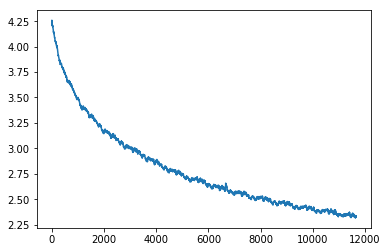

In [64]:
learner.sched.plot_loss()

## Classifier tokens

La partie clas

In [65]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'val.csv', header=None, chunksize=chunksize)
df_real_test = pd.read_csv(CLAS_PATH/'real_test.csv', header=None, chunksize=chunksize)

In [66]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_real_test, real_test_labels = get_all(df_real_test, 1)

0
0
0


In [67]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_real_test.npy', tok_real_test)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
np.save(CLAS_PATH/'tmp'/'real_test_labels.npy', real_test_labels)

In [68]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_real_test = np.load(CLAS_PATH/'tmp'/'tok_real_test.npy')
print(len(tok_real_test))

13656


In [69]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

17014

In [70]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
real_test_clas = np.array([[stoi[o] for o in p] for p in tok_real_test])

In [71]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'real_test_ids.npy', real_test_clas)

## Classifier

Le classifieur est un perceptron avec une couche cachée.

In [72]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
real_test_clas = np.load(CLAS_PATH/'tmp'/'real_test_ids.npy')

In [73]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
real_test_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'real_test_labels.npy'))

In [74]:
bptt,em_sz,nh,nl = 420,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [75]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [76]:
print(val_labels)

[0 3 2 ... 3 1 0]


Dans le classificateur, contrairement au LM, nous devons lire un texte à la fois et apprendre à prédire le niveau de l'étudiant. Comme les textes n'ont pas tous la même taille, il faut ajouter du padding. Cependant si dans un même batch les textes ont des longueurs très différentes: certains textes auront beaucoup de padding. Le réseau va lire beaucoup de mots vides ce qui altère sa performance.

SortishSampler crée des batchs en triant les textes par longueur et ajoute un peu d'aléatoire pour que le parcours des textes ne soit pas systématiquement le même à chaque epoch.

In [77]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
real_test_ds = TextDataset(real_test_clas, real_test_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
real_test_dl = DataLoader(real_test_ds, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(PATH, trn_dl, val_dl, real_test_dl)

In [78]:
print(len(real_test_clas))
print(len(real_test_ds.x))
print(len(real_test_ds.y))

13656
13656
13656


In [79]:
# part 1
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [80]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [81]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 150, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3], 
          #bidir=True
            )

In [82]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [83]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy, cost_competition]

In [84]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [85]:
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [86]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm1_enc')
#wgts['0.rnns.0.module.weight_ih_l0']

In [87]:
learn.freeze_to(-1)

In [88]:
#learn.lr_find(lrs/1000)
#learn.sched.plot()

In [89]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   cost_competition 
    0      0.650449   0.390241   0.871375   0.761186  


[array([0.39024]), 0.8713749865496607, 0.7611860581607961]

In [90]:
learn.save('clas_0')

In [91]:
learn.load('clas_0')

In [92]:
learn.freeze_to(-2)

In [93]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy   cost_competition 
    0      0.444927   0.301131   0.906994   0.544438  


[array([0.30113]), 0.9069936159298378, 0.5444383464903154]

In [94]:
learn.save('clas_1')

In [95]:
learn.load('clas_1')

In [96]:
learn.unfreeze()

Early stopping sur la précision (et non pas sur l'entropie croisée).

In [97]:
callbacks = []
callbacks.append(EarlyStopping(learn, 'clas_2', patience=5, metric=2, smaller_is_better=True))
learn.fit(lrs, 1, wds=wd, cycle_len=20, use_clr=(32,10), callbacks=callbacks)

epoch      trn_loss   val_loss   accuracy   cost_competition 
    0      0.301554   0.282647   0.898976   0.666307  
    1      0.259557   0.199172   0.931802   0.396308         
    2      0.216917   0.208888   0.934468   0.34903          
    3      0.109649   0.236315   0.933034   0.437573         
    4      0.10057    0.205265   0.946929   0.321998          
    5      0.080589   0.223245   0.942087   0.346486          
    6      0.061516   0.177323   0.955369   0.242854          
    7      0.0339     0.221921   0.950517   0.295319          
    8      0.053111   0.220378   0.959283   0.209153          
    9      0.033159   0.249981   0.958026   0.202753          
    10     0.012676   0.163538   0.961344   0.200368          
    11     0.028391   0.177262   0.961535   0.188484          
    12     0.018196   0.175446   0.965843   0.158601           
    13     0.01624    1.256455   0.956636   0.23929            
    14     0.007643   0.232047   0.961665   0.204301           
 

[array([0.22037]), 0.9595108033466517, 0.20712210628505945]

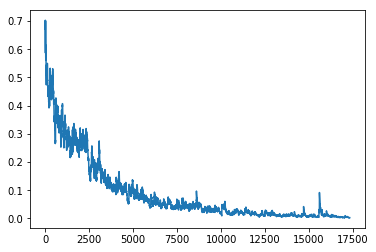

In [98]:
learn.sched.plot_loss()

In [99]:
learn.save('clas_2')

In [100]:
learn.load('clas_2')

In [101]:
costs = np.array([[0,1,2,3,4,6],[1,0,1,4,5,8],[3,2,0,3,5,8],[10,7,5,0,2,7],[20,16,12,4,0,8],[44,38,32,19,13,0]])
names = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

Confusion matrix, without normalization
[[2321   10    1    0    2    0]
 [  13 1470   12    2    0    0]
 [   5   25 1008   12    2    0]
 [   2    5   12  450    4    0]
 [   1    1    3    5   88    1]
 [   0    0    0    2    1    4]]


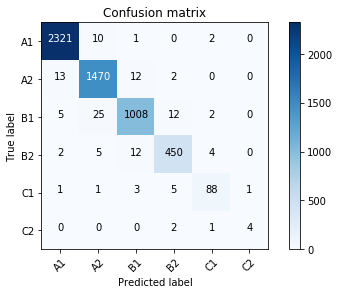

Normalized confusion matrix
[[0.99 0.   0.   0.   0.   0.  ]
 [0.01 0.98 0.01 0.   0.   0.  ]
 [0.   0.02 0.96 0.01 0.   0.  ]
 [0.   0.01 0.03 0.95 0.01 0.  ]
 [0.01 0.01 0.03 0.05 0.89 0.01]
 [0.   0.   0.   0.29 0.14 0.57]]


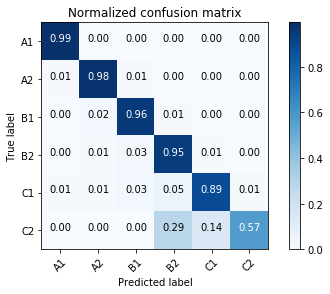

(0.08019040644452581, array([ 20,  33, 111, 123, 100,  51]))


In [102]:
y_pred_logits, y_val2 = learn.predict_with_targs()
print(cost_competition(y_pred_logits, y_val2, print_confusion = True, cost_by_level = True))

# Submission

In [103]:
y_pred = np.argmax(learn.predict_dl(real_test_dl), axis=1)

In [104]:
print(y_pred)
print(len(y_pred))
#y = np.array(real_test_y.replace({"A1": 0, "A2" : 1, "B1" : 2, "B2" : 3, "C1" : 4, "C2" : 5}))
#print(y)

[0 1 1 ... 2 0 1]
13656


In [105]:
#print(len(y_pred))
#print(real_test_y.shape)
#print(cost(y_pred, y))

In [106]:
def replace_level(int_level):
    str_level = ""
    if int_level==0:
        str_level = "A1"
    elif int_level==1:
        str_level = "A2"
    elif int_level==2:
        str_level = "B1"
    elif int_level==3:
        str_level = "B2"
    elif int_level==4:
        str_level = "C1"
    elif int_level==5:
        str_level = "C2"
    return str_level

In [107]:
!mkdir submissions
import csv
i = 0
with open('submissions/submission.csv', 'w') as csvfile:
    fieldnames = ['text', 'level']
    writer = csv.DictWriter(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(y_pred)):
        writer.writerow({fieldnames[0]: str(i), fieldnames[1]: replace_level(y_pred[i])})
        
        

mkdir: cannot create directory ‘submissions’: File exists


In [108]:
!cat submissions/submission.csv